In [2]:
import os
import sys
import time
import networkx as nx

from cdlib import algorithms
import matplotlib.pyplot as plt
from typing import List, Optional
from pyvis.network import Network
from utils import get_token_count

from pydantic import BaseModel, ValidationError

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'bayanpy', 'infomap', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Assuming the project root is one level up from the current directory
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the project root to the Python path
sys.path.append(project_root)

from document_processing import merge_chunks
from prompts import get_entities, get_entity_types

In [4]:
CHUNKS = merge_chunks(0)

Guest name(s) is(are) Sholto Douglas & Trenton Bricken


In [5]:
len(CHUNKS)

47

In [6]:
class Entity(BaseModel):
    name: str
    type: str
    description: Optional[str] = None

class Relationship(BaseModel):
    source: str
    target: str
    relationship: str
    relationship_strength: int

class Response(BaseModel):
    entities: List[Entity]
    relationships: List[Relationship]

In [7]:
G = nx.Graph()

In [13]:
for idx, chunk in enumerate(CHUNKS[19:25]):
    print(f"Processing chunk {idx + 19}")
    entities, rltns = get_entities(chunk)

    for entity in entities:
        G.add_node(entity.name, type=entity.type, description=entity.description)
    for relationship in rltns:
        G.add_edge(relationship.source, relationship.target, relationship=relationship.relationship, strength=relationship.relationship_strength)

    time.sleep(30)


Processing chunk 19
Processing chunk 20
Processing chunk 21
Processing chunk 22
Processing chunk 23
Processing chunk 24


# Pyvis, with degree sizes and stuff

In [14]:
color_map = {
    'person': '#FF6B6B',    # coral red
    'organizations': '#4ECDC4',    # turquoise
    'concepts': '#45B7D1',    # blue
    'event': '#96CEB4',    # sage green
    'algorithm': '#233FFF',    # deep blue
    'AI models': '#FFD700',    # gold
    'datasets': '#FFA07A',    # light salmon
    'events': '#96CEB4',    # sage green
    'AI researchers': '#FF6B6B',    # coral red
    'AI capabilities': '#45B7D1',    # blue
    'research papers': '#8A2BE2',    # blue violet
    'technical metrics': '#FF4500',    # orange red
    'technical concepts': '#45B7D1',    # blue
    'evaluation tasks': '#96CEB4',    # sage green
    'neural network components': '#233FFF',    # deep blue
    'biological analogy': '#FFD700',    # gold
    'time scales': '#FFA07A',    # light salmon
    'human brain components': '#FF6B6B',    # coral red
    'brain function': '#45B7D1',    # blue
    'memory systems': '#8A2BE2',    # blue violet
    'neural imaging techniques': '#FF4500',    # orange red
    'cognitive processes': '#45B7D1',    # blue
    'biological systems': '#96CEB4',    # sage green
    'medical conditions': '#233FFF',    # deep blue
    'information representation': '#FFD700',    # gold
    'learning processes': '#FFA07A',    # light salmon
    'intelligence concepts': '#FF6B6B',    # coral red
    'model training components': '#45B7D1',    # blue
    'business entities': '#4ECDC4',    # turquoise
    'financial metrics': '#8A2BE2',    # blue violet
    'compute resources': '#FF4500',    # orange red
    'research fields': '#45B7D1',    # blue
    'research concepts': '#96CEB4',    # sage green
    'research programs': '#233FFF',    # deep blue
    'research processes': '#FFD700',    # gold
    'research bottleneck': '#FFA07A',    # light salmon
    'research organization': '#FF6B6B',    # coral red
    'web frameworks': '#45B7D1',    # blue
}


In [15]:

# Calculate node sizes based on degree (number of connections)
# Get the degree of each node
degrees = dict(G.degree())
# Scale the sizes - you can adjust these numbers
min_size = 20
max_size = 50
min_degree = min(degrees.values())
max_degree = max(degrees.values())

# Create a Pyvis network object
net = Network(notebook=True, cdn_resources='remote')

# Add nodes to Pyvis network with colors and sizes
for node in G.nodes():
    # Get node type
    try:
        node_type = G.nodes[node]['type']
    except Exception as e:
        pass
    # Get color from mapping, default to grey if type not found
    color = color_map.get(node_type, '#999999')
    
    # Calculate scaled node size
    if max_degree > min_degree:  # Prevent division by zero
        size = min_size + (max_size - min_size) * (degrees[node] - min_degree) / (max_degree - min_degree)
    else:
        size = min_size
        
    # Add node with color and size
    try:
        net.add_node(node, 
                    color=color,
                    size=size,
                    title=f"Type: {node_type}\nDegree: {degrees[node]}\nDescription: {G.nodes[node]['description']}")
    except Exception as e:
        net.add_node(node, 
                    size=size,
                    title=f"Degree: {degrees[node]}")

# Add edges to Pyvis network
for edge in G.edges():
    source, target = edge
    edge_data = G.edges[edge]
    net.add_edge(source, target, 
                 title=f"Relationship: {edge_data['relationship']}\nStrength: {edge_data['strength']}")

# Configure other visualization options
net.toggle_physics(True)
net.show_buttons(filter_=['physics'])

# Save and show the network
net.show("network.html")

network.html


# Communities

In [16]:
def detect_communities(graph):
    communities = []
    index = 0
    for component in nx.connected_components(graph):
        print(
            f"Component index {index} of {len(list(nx.connected_components(graph)))}:")
        subgraph = graph.subgraph(component)
        if len(subgraph.nodes) > 1:  # Leiden algorithm requires at least 2 nodes
            try:
                sub_communities = algorithms.leiden(subgraph)
                for community in sub_communities.communities:
                    communities.append(list(community))
            except Exception as e:
                print(f"Error processing community {index}: {e}")
        else:
            communities.append(list(subgraph.nodes))
        index += 1
    print("Communities from detect_communities:", communities)
    return communities

community = detect_communities(G)

Component index 0 of 64:
Component index 1 of 64:
Component index 2 of 64:
Error processing community 2: invalid literal for int() with base 10: 'NeurIPS'
Component index 3 of 64:
Component index 4 of 64:
Component index 5 of 64:
Component index 6 of 64:
Error processing community 6: invalid literal for int() with base 10: 'attention'
Component index 7 of 64:
Component index 8 of 64:
Component index 9 of 64:
Component index 10 of 64:
Component index 11 of 64:
Error processing community 11: invalid literal for int() with base 10: 'residual stream'
Component index 12 of 64:
Error processing community 12: invalid literal for int() with base 10: 'read-write operations'
Component index 13 of 64:
Component index 14 of 64:
Component index 15 of 64:
Component index 16 of 64:
Error processing community 16: invalid literal for int() with base 10: 'Cerebellum'
Component index 17 of 64:
Component index 18 of 64:
Error processing community 18: invalid literal for int() with base 10: 'working memory

In [21]:
sc = community[1]

subG = G.subgraph(sc)

In [23]:
subG.edges()[('AI Model Training', 'Sholto Douglas')]

{'relationship': 'Works on improving the training process for AI models',
 'strength': 9}

In [28]:
def plot_graph(G):
    # Visualize the graph using matplotlib
    plt.figure(figsize=(30, 30))

    # Draw the nodes
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="skyblue")

    # Draw the edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Draw the labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    # Draw the edge labels
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Show the plot
    plt.title("Network Graph")
    plt.show()

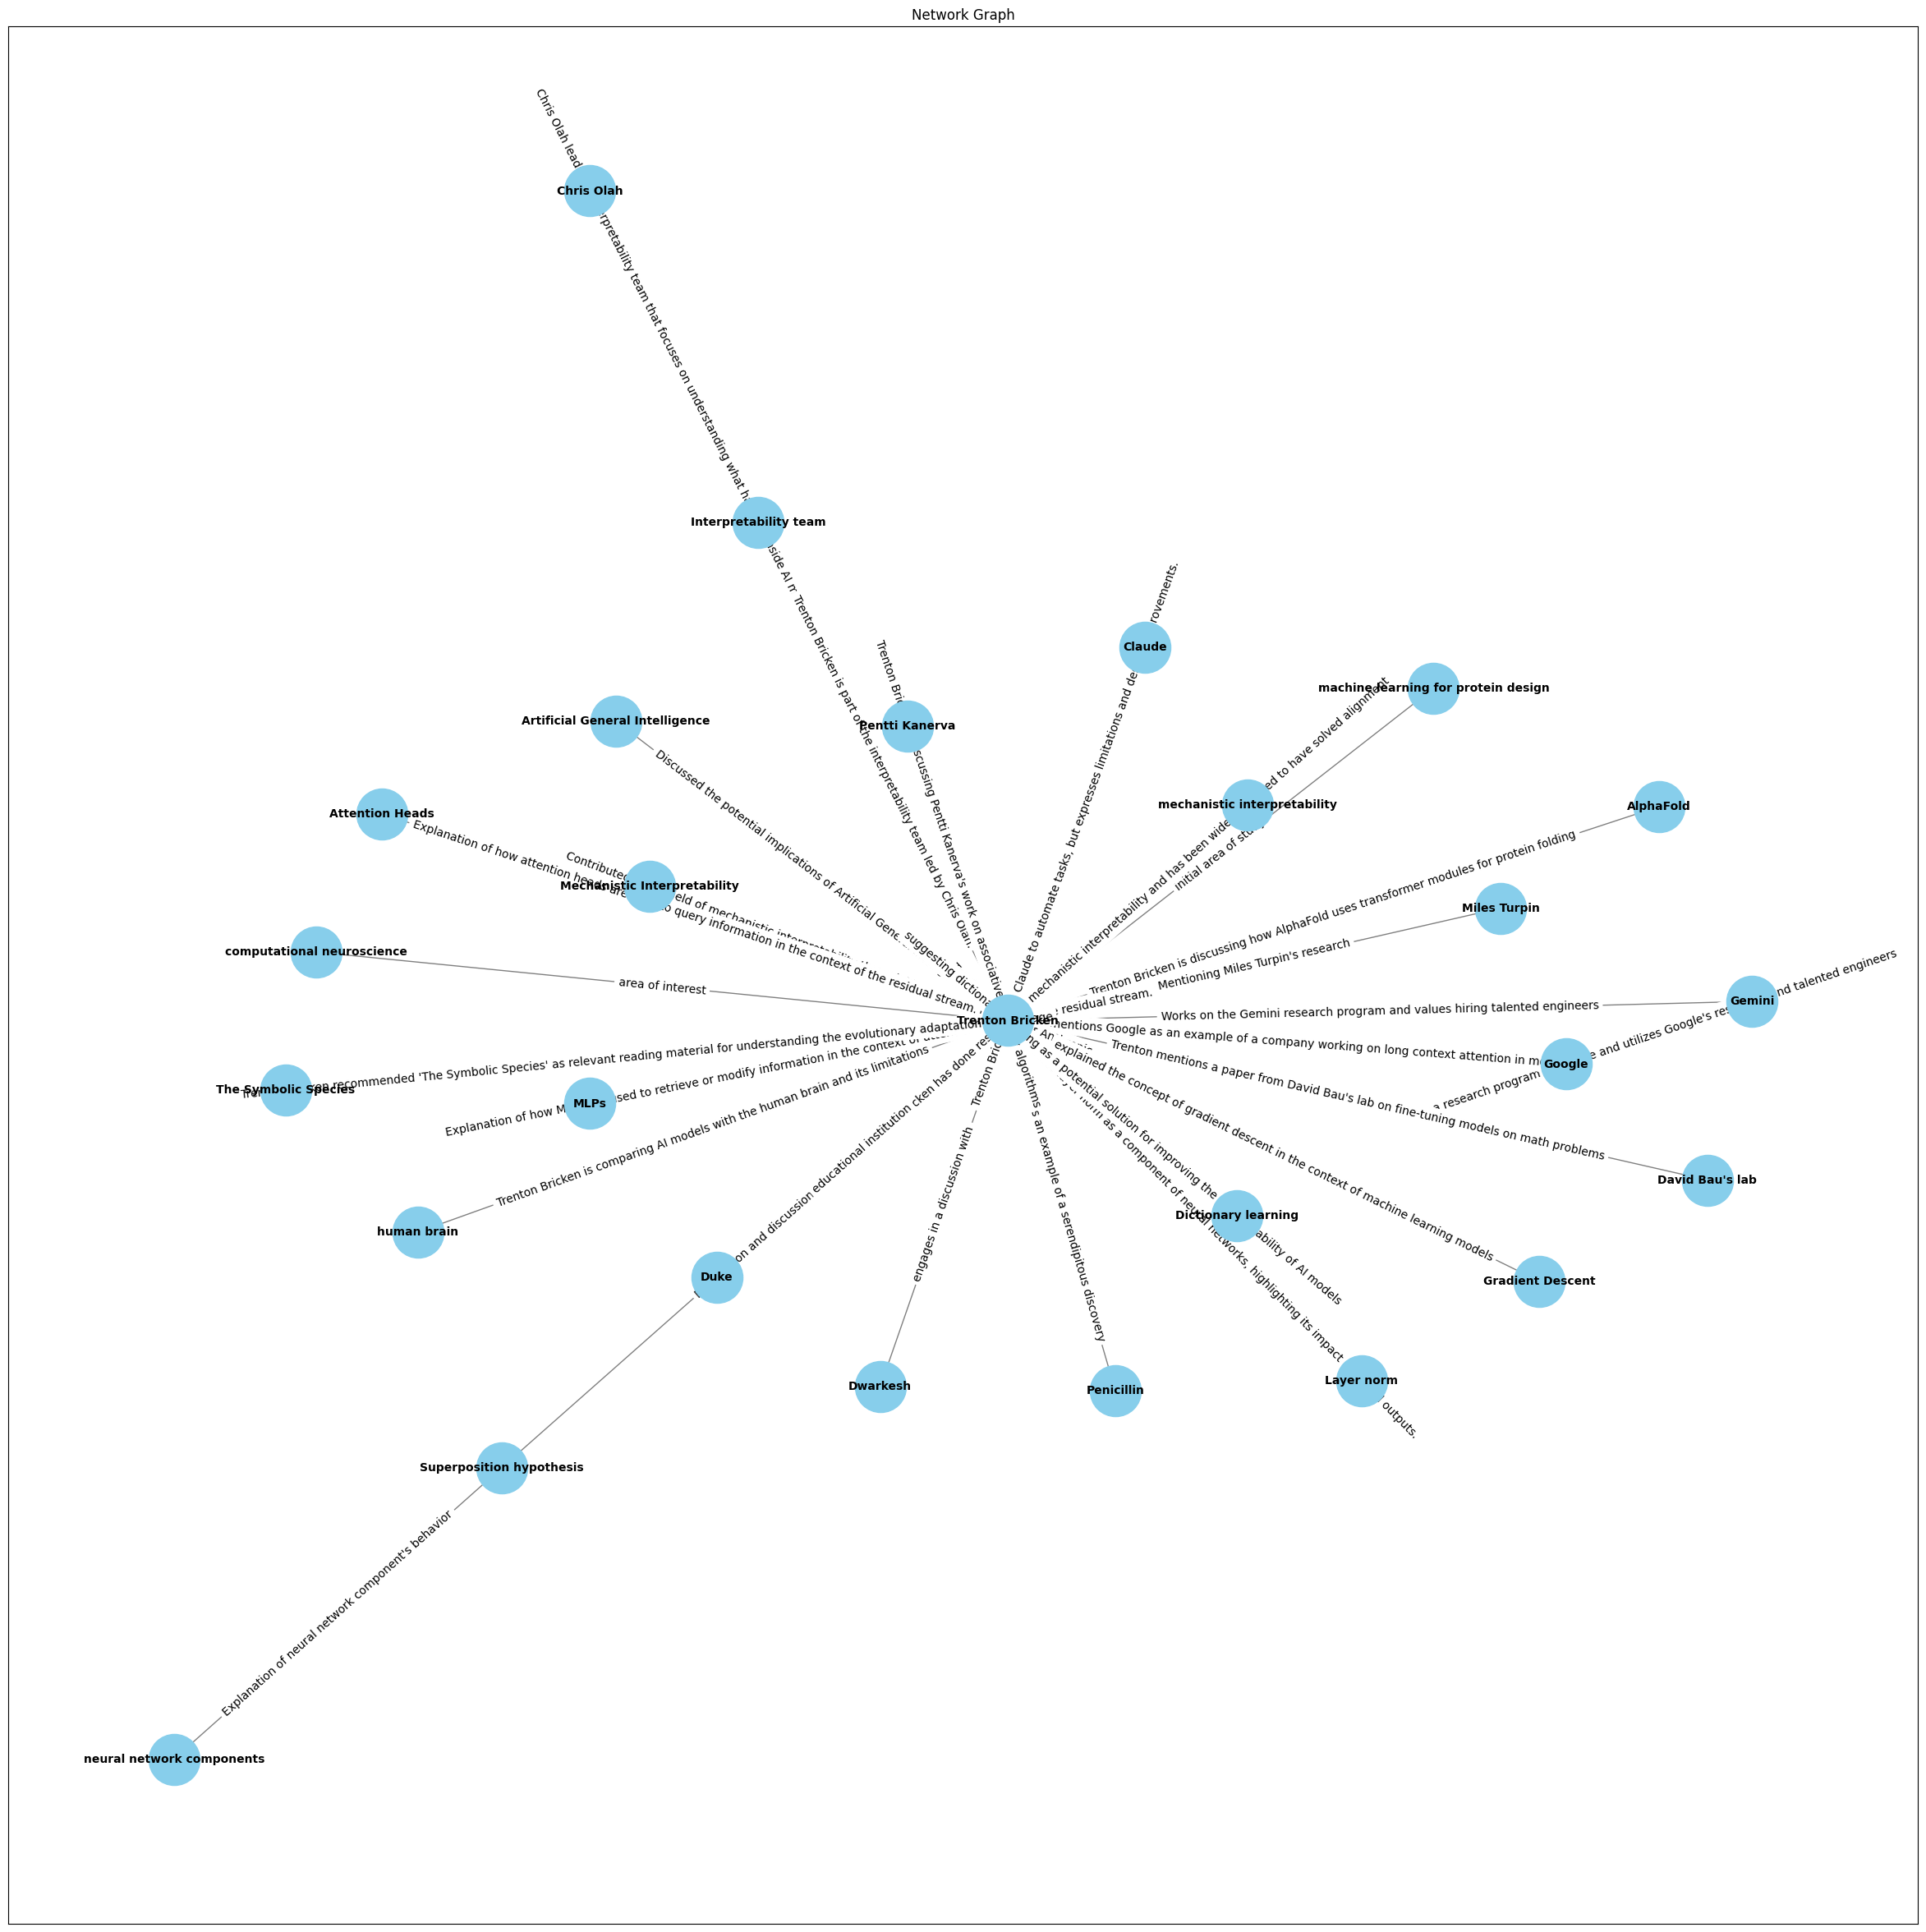

In [29]:
plot_graph(subG)

# Get All entity types

In [73]:
LIST_OF_ENTITIES = []
EROR_CASES = []

In [74]:
for idx in range(10, 47):
    print(f"Processing chunk at index {idx}")
    entity_types = get_entity_types(CHUNKS[idx])

    print(entity_types)

    if isinstance(entity_types[0], str):
        for st in entity_types:
            LIST_OF_ENTITIES.append(st)
    else:
        EROR_CASES.extend(entity_types)
    
    time.sleep(30)

Processing chunk at index 10
['person', 'AI models', 'research concepts', 'organization', 'technical concepts', 'software engineering concepts']
Processing chunk at index 11
['person', 'research programs', 'organizations', 'technologies', 'concepts']
Processing chunk at index 12
['person', 'concept', 'technology', 'research']
Processing chunk at index 13
['concepts', 'research areas', 'AI models', 'person', 'techniques', 'fields of study', 'organizations']
Processing chunk at index 14
Error occured in entity_types_extraction.py
[{"type":"missing","loc":["entity_types"],"msg":"Field required","input":{"entities":["person","AI models","algorithm","technological advancements","researchers","concepts"]},"url":"https://errors.pydantic.dev/2.9/v/missing"}]
Processing chunk at index 15
['person', 'AI models', 'concept', 'organizations', 'technological advancements']
Processing chunk at index 16
['person', 'AI models', 'research papers', 'concepts']
Processing chunk at index 17
['person', 'con

KeyboardInterrupt: 

In [53]:
len(LIST_OF_ENTITIES)

2646

In [55]:
new_list = [string for string in list(set(LIST_OF_ENTITIES)) if len(string) > 2]

In [57]:
new_list = [string.lower() for string in new_list]
new_list = list(set(new_list))

In [58]:
for x in new_list:
    print(x)

conference
science field
brain regions
architectural firms
research metrics
math problems
research organization
theoretical frameworks
organization
ai concept
intelligence explosion models
technical concepts
researcher
human languages
location
hypothetical scenarios
company
research concepts
technology
research field
technical processes
technique
reinforcement learning
hardware
philosophical hypothesis
research benchmarks
compute resources
concept
technologies
game
ai models
computing resources
project
theories
brain anatomy
neural structure
characters
methods
person
field of study
books
modalities
language
paper
games
idea
competition
evaluation metrics
events
neural networks
educational programs
fields_of_study
funding amount
people
mechanisms
neurological concepts
techniques
ai model
organizational entities
analogies
neural models
experiments
technological processes
university
literary work
computational representation
ai concepts
field
research papers
theory
algorithm
hardware comp

In [ ]:
'events', "person", "organization", "research areas", "projects",
"fields of study", "evaluation tasks" "evaluation method" "philosophical hypothesis", "technical processes"
"hardware component" "books" "research paper" "algorithm" "hypothetic"
"web frameworks" "human languages" "programming languages" "AI model" "AI concepts" "theories" "research method"


"technology"

# CHUNKS

In [1]:
for idx in range(12, 14):
    print(CHUNKS[idx])

NameError: name 'CHUNKS' is not defined

# Community-type shit

In [49]:
COMMUNITY_REPORT_SUMMARIZATION_PROMPT = """
You are a data analyst, listening to a conversation between a couple of AI scientists and trying to draw as much insight as possible. You are also a very helpful researcher. 

# Goal
Write a comprehensive assessment report of a community taking on the role of a knowledgeable AI scientist and researcher. The content of this report includes an overview of the community's key entities and relationships.

# Report Structure
The report should include the following sections:
- TITLE: community's name that represents its key entities - title should be short but specific. When possible, include representative named entities in the title.
- SUMMARY: An executive summary of the community's overall structure, how its entities are related to each other, and significant points associated with its entities.
- DETAILED FINDINGS: A list of 5-20 key insights about the community. Each insight should have a short summary followed by multiple paragraphs of explanatory text grounded according to the grounding rules below. Be comprehensive. Include entities where possible in the explanatory text.

Return output as a well-formed JSON-formatted string with the following format. Don't use any unnecessary escape sequences. The output should be a single JSON object that can be parsed by json.loads.
    {{
        "title": "<report_title>",
        "summary": "<executive_summary>",
        "findings": "[{{"summary":"<insight_1_summary>", "explanation": "<insight_1_explanation"}}, {{"summary":"<insight_2_summary>", "explanation": "<insight_2_explanation"}}]"
    }}

# Grounding Rules
Each paragraph should contain multiple sentences of explanation and concrete examples with specific named entities. All paragraphs must have these references at the start and end. Use "NONE" if there are no related roles or records.

# Example Input
-----------
Text:

Entities

entity,description
ABILA CITY PARK,Abila City Park is the location of the POK rally

Relationships

source,target,description
ABILA CITY PARK,POK RALLY,Abila City Park is the location of the POK rally
ABILA CITY PARK,POK,POK is holding a rally in Abila City Park
ABILA CITY PARK,POKRALLY,The POKRally is taking place at Abila City Park
ABILA CITY PARK,CENTRAL BULLETIN,Central Bulletin is reporting on the POK rally taking place in Abila City Park

Output:
{{
    "title": "Abila City Park and POK Rally",
    "summary": "The community revolves around the Abila City Park, which is the location of the POK rally. The park has relationships with POK, POKRALLY, and Central Bulletin, all
of which are associated with the rally event.",
    "findings": [
        {{
            "summary": "Abila City Park as the central location",
            "explanation": "Abila City Park is the central entity in this community, serving as the location for the POK rally. This park is the common link between all other
entities, suggesting its significance in the community. The park's association with the rally could potentially lead to issues such as public disorder or conflict, depending on the
nature of the rally and the reactions it provokes."
        }},
        {{
            "summary": "POK's role in the community",
            "explanation": "POK is another key entity in this community, being the organizer of the rally at Abila City Park. The nature of POK and its rally could be a potential
source of threat, depending on their objectives and the reactions they provoke. The relationship between POK and the park is crucial in understanding the dynamics of this community."
        }},
        {{
            "summary": "POKRALLY as a significant event",
            "explanation": "The POKRALLY is a significant event taking place at Abila City Park. This event is a key factor in the community's dynamics and could be a potential
source of threat, depending on the nature of the rally and the reactions it provokes. The relationship between the rally and the park is crucial in understanding the dynamics of this
community."
        }},
        {{
            "summary": "Role of Central Bulletin",
            "explanation": "Central Bulletin is reporting on the POK rally taking place in Abila City Park. This suggests that the event has attracted media attention, which could
amplify its impact on the community. The role of Central Bulletin could be significant in shaping public perception of the event and the entities involved."
        }}
    ]
}}

# Real Data

Use the following text for your answer. Do not make anything up in your answer.

Text:
{input_text}
Output:"""

In [24]:
sc = community[0]
subG = G.subgraph(sc)

In [32]:
subG.nodes()['Google']

{'type': 'business entities',
 'description': 'Technology company, provided environment for Sholto Douglas to learn from experts in algorithms and systems'}

In [40]:
nodes_context = []
for node in subG.nodes():
    # print(node, subG.nodes()[node]['description'])
    info = f"{node},{subG.nodes()[node]['description']}"
    nodes_context.append(info)

In [48]:
edges_context = []
for edge in subG.edges():
    info = f"{edge[0]},{edge[1]},{subG.edges()[edge]['relationship']}"
    print(info)

computational neuroscience,Trenton Bricken,area of interest
machine learning for protein design,Trenton Bricken,initial area of study
human brain,Trenton Bricken,Trenton Bricken is comparing AI models with the human brain and its limitations
Gemini,Trenton Bricken,Works on the Gemini research program and values hiring talented engineers
Gemini,Google,Is a research program at Google and utilizes Google's resources and talented engineers
Layer norm,Trenton Bricken,Trenton Bricken discusses layer norm as a component of neural networks, highlighting its impact on model outputs.
Chris Olah,Interpretability team,Chris Olah leads the interpretability team that focuses on understanding what happens inside AI models.
Miles Turpin,Trenton Bricken,Mentioning Miles Turpin's research
AlphaFold,Trenton Bricken,Trenton Bricken is discussing how AlphaFold uses transformer modules for protein folding
Superposition hypothesis,neural network components,Explanation of neural network component's behavior
S

In [50]:
prompt = COMMUNITY_REPORT_SUMMARIZATION_PROMPT.format(input_text = nodes_context + edges_context)

In [52]:
prompt

'\nYou are a data analyst, listening to a conversation between a couple of AI scientists and trying to draw as much insight as possible. You are also a very helpful researcher. \n\n# Goal\nWrite a comprehensive assessment report of a community taking on the role of a knowledgeable AI scientist and researcher. The content of this report includes an overview of the community\'s key entities and relationships.\n\n# Report Structure\nThe report should include the following sections:\n- TITLE: community\'s name that represents its key entities - title should be short but specific. When possible, include representative named entities in the title.\n- SUMMARY: An executive summary of the community\'s overall structure, how its entities are related to each other, and significant points associated with its entities.\n- DETAILED FINDINGS: A list of 5-20 key insights about the community. Each insight should have a short summary followed by multiple paragraphs of explanatory text grounded accordin

In [53]:
from utils import get_token_count

get_token_count(prompt)

1638

In [ ]:
from dataclasses import dataclass

PROMPT = """
            Do something in this graph right here.
        """

@dataclass
class Graphrag:
    # base graph

    # community
    community_id: int
    community_nodes: List[str]
    community_summary: Optional[str] = None
    community_factual_findings: dict 

    def get_community_summaries(self):
        assert self.community_summary is None, "Graph summaries filled already"

        for community_idx in range(len(self.community_nodes)):
            graph = self.community_nodes[community_idx]
            subG = G.subgraph(graph)

            
            

        


        

## Things left to do
    # Community summary
        # A community, currently is just a list of nodes. I can store this in a dataclass. 
        # For each community summary I generate for a class, I also generate a list of findings for the community. This is also 
            stored in the dataclass.
        # Each findings should also be vectorized in a database. This will be what I will do vector query against.
    # How to process a query
        1. For each query, I run it against all the findings in the vector databse and use all the findings as context for the queries.
    # Making the code good and all that